1. purpose: make a tiny gradient decent library.
2. design:
  * class Value: support basic operations, like +/-/*///**, autograd, and backward
  * class Neuron: multiple input, one output.
  * class Layer: multiple neurons sharing same multiple inputs
  * class MLP: multiple layers
3. Test:
  an MLP instance with our library. and compare its output with Torch's MLP output
4. Demo:
  train an MLP to classify two clusters

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.functional as F
import random
from functools import reduce

In [2]:
wa = torch.Tensor([2])
wb = torch.Tensor([1])
wc = torch.Tensor([3])
for w in [wa,wb,wc]:
  w.requires_grad = True

input = torch.Tensor([1,2])
vd = wa*input[0]+wb*input[1]+wc # w@input+b
print(f'vd:{vd} id:{id(vd)}')
vf = vd + wa*input[0]
print(f'vf:{vf} id:{id(vf)}')
vf.backward()

for t in [wa,wb,wc,vd,vf,input[0],input[1]]:
  print(f'{t}: grad:{t.grad}')

vd:tensor([7.], grad_fn=<AddBackward0>) id:137581274397392
vf:tensor([9.], grad_fn=<AddBackward0>) id:137581274394416
tensor([2.], requires_grad=True): grad:tensor([2.])
tensor([1.], requires_grad=True): grad:tensor([2.])
tensor([3.], requires_grad=True): grad:tensor([1.])
tensor([7.], grad_fn=<AddBackward0>): grad:None
tensor([9.], grad_fn=<AddBackward0>): grad:None
1.0: grad:None
2.0: grad:None


<ipython-input-2-70b4af76085e>:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print(f'{t}: grad:{t.grad}')


In [202]:
class Value:
  def __init__(self, data, deps={}, requires_grad=True):
    self.data = float(data)
    self.grad = 0
    self.requries_grad = requires_grad
    self.grad_fn = lambda:None
    self.grad = float(0)
    self.deps = deps
    #print(f'new Value {id(self) % 1000} {type(self.data)} {self.data} deps: {[id(dep)%1000 for dep in deps]}')

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, {self, other})

    def _grad_fn():
      # Do/Da = 1; Do/Db = 1
      self.grad += out.grad
      other.grad += out.grad

    out.grad_fn = _grad_fn
    return out

  def __radd__(self, other):
    return self.__add__(other)

  def __sub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data - other.data,{self, other})

    def _grad_fn():
      # Do/Da = 1; Do/Db = -1
      self.grad += out.grad

    out.grad_fn = _grad_fn
    return out

  def __rsub__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return  other.__sub__(self)

  def __neg__(self):
    return self.__mul__(-1)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data,{self, other})

    def _grad_fn():
      # Do/Da = b; Do/Db = a
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data

    out.grad_fn = _grad_fn
    return out

  def __rmul__(self, other):
    return self.__mul__(other)

  def __div__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data / other.data,{self, other})

    def _grad_fn():
      # Do/Da = 1/b; Do/Db = a*-1*b**-2
      self.grad += out.grad / other.data
      other.grad -= out.grad * self.data / other.data ** 2

    out.grad_fn = _grad_fn
    return out

  def __truediv__(self, other):
    return self.__div__(other)

  def __rdiv__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    return other.__div__(self)

  def __rtruediv__(self, other):
    return self.__rdiv__(other)

  def __pow__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data ** other.data,{self, other})

    def _grad_fn():
      # Do/Da = b*a**(b-1)
      self.grad += out.grad * other.data * self.data ** (other.data - 1)

    out.grad_fn = _grad_fn
    return out

  def tanh(self):
    x = self.data
    t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
    out = Value(t, {self})

    def _grad_fn():
      # Do/Da = 1 - t**2
      self.grad += out.grad * (1 - t**2)

    out.grad_fn = _grad_fn
    return out

  def relu(self):
    out = Value(0 if self.data < 0 else self.data, {self})

    def _grad_fn():
        self.grad += out.grad * (1 if self.data > 0 else 0)

    out.grad_fn = _grad_fn
    return out

  def __repr__(self):
    return f'Value(data={self.data} grad_fn={self.grad_fn} grad={self.grad})'

  def backward(self):
    visited = set()
    queue = list()

    def visit(node):
      if node not in visited:
        # print(f'visit {id(node)%1000} {node.grad}')
        visited.add(node)
        for dep in node.deps:
          visit(dep)
        queue.append(node)
    visit(self)

    self.grad = 1
    for node in reversed(queue):
      node.grad_fn()
    #print(f'backward done. visited:{len(visited)} queue: {len(queue)} ')

v = Value(3)
1+-v*3

Value(data=-8.0 grad_fn=<function Value.__add__.<locals>._grad_fn at 0x7d2109082520> grad=0.0)

In [95]:
### test
wa = Value(2, requires_grad=True)
wb = Value(4, requires_grad=True)
wc = Value(3, requires_grad=True)

input = Value(2)
vd = wa*input + wb*input + wc # w@input+b
vf = vd + wa**2*input
vf.backward()

grads1 = [wa.grad, wb.grad, wc.grad]
print(f'grad1:{grads1}')

wa = torch.Tensor([2])
wb = torch.Tensor([4])
wc = torch.Tensor([3])
for w in [wa,wb,wc]:
  w.requires_grad = True

input = torch.Tensor([2])
vd = wa*input+wb*input+wc # w@input+b
vf = vd + wa**2*input
vf.backward()
grad2 = [wa.grad.item(), wb.grad.item(), wc.grad.item()]
print(f'grad2:{grad2}')

assert grads1 == grad2, "test fail"
print("test pass")

grad1:[10.0, 2.0, 1.0]
grad2:[10.0, 2.0, 1.0]
test pass


In [96]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(0)
    #self.w = [Value(0.1) for _ in range(nin)]
    #self.b = Value(0.2)

  def parameters(self):
    # print(f"report {len(self.w) + 1} parameters")
    return self.w + [self.b]

  def __call__(self, x):
    # print(f'Neuron {len(self.w)} {id(x)}')
    output = reduce(lambda s,y:s+y, [wi*xi for wi,xi in zip(self.w, x)]) + self.b
    return output.relu()

  def __repr__(self):
    return f'Neuron:{len(self.w)}'

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

  def __call__(self, x):
    return [n(x) for n in self.neurons]

  def __repr__(self):
    return f'\nLayer:{len(self.neurons)} of {str(self.neurons[0])}'

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sin, sout) for sin,sout in zip(sz[0:], sz[1:])]

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def __call__(self, x):
    x = list(x)
    #print(f'x:{x}')
    for layer in self.layers:
      x = layer(x)

    return x if len(x) > 1 else x[0]

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0

  def __repr__(self):
    return f'MLP:{",".join([str(layer) for layer in self.layers])}'

14.639999999999999

In [91]:
''' unit test '''
''' MLP '''
# make network
mlp1 = MLP(3,[4,4,1])

# forward pass
output = mlp1([1,2,3])
output2 = mlp1([3,4,5])
print(f'mlp output: {output.data}, {output2.data}')

# backward
mlp1.zero_grad()
reduce(lambda s,x:s+x,[output,output2]).backward()

sum_grad1 = reduce(lambda s,x:s+x, [x.grad for x in mlp1.parameters()])

''' Torch nn '''
mlp2 = torch.nn.Sequential(
    torch.nn.Linear(3,4, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(4,4, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1, bias=True),
    torch.nn.ReLU(),
    )
def init_params(layer):
  if type(layer) == torch.nn.Linear:
    torch.nn.init.uniform_(layer.weight, -1, 1)
    torch.nn.init.uniform_(layer.bias, -1, 1)
    #layer.weight.data = torch.ones(layer.weight.shape) * 0.1
    #layer.bias.data = torch.ones(layer.bias.shape) * 0.2
mlp2.apply(init_params)

output = mlp2(torch.Tensor([1,2,3]))
output2 = mlp2(torch.Tensor([3,4,5]))
print(f'tensor nn output: {output.item()}, {output2.item()}')

mlp2.zero_grad()
reduce(lambda s,x:s+x, output,output2).backward()

sum_grad2 = reduce(lambda s,x:s+x, [x.grad.sum() for x in mlp2.parameters()])

''' asset same result'''
assert abs(sum_grad1 - sum_grad2) < 1e-6, f"test fail {sum_grad1} != {sum_grad2}"
print("test pass")

mlp output: 0.40800000000000003, 0.504
tensor nn output: 0.40800002217292786, 0.5040000081062317
test pass


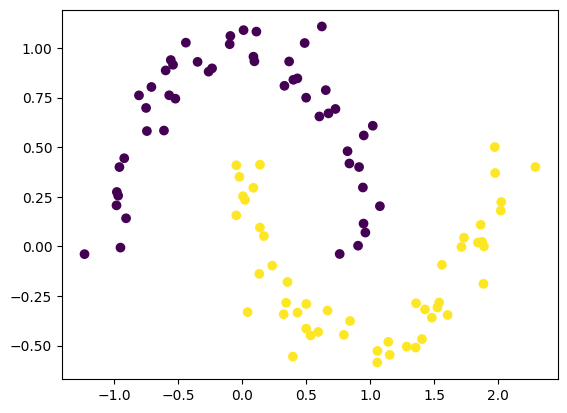

In [92]:
'''train an MLP to classify two clusters'''
from sklearn.datasets import make_moons
data_X,data_y=make_moons(n_samples=100, noise=0.1)
data_y = data_y * 2 -1
plt.scatter(data_X[:,0],data_X[:,1],c=data_y)

In [ ]:
model = MLP(2, [16,16,1])
print(model)
print("number of parameters", len(model.parameters()))

train_size = int(data_X.shape[0] * 1.0)
print(f'train size:{train_size} {data_X.shape} {data_y.shape}')

train_X,train_y = data_X[0:train_size,:],data_y[0:train_size]

#inputs = [list(map(Value, xrow)) for xrow in train_X]

num_epoches = 100

# train
train_losses = []
accuracys = []
for epoch in range(num_epoches):
  print(f'epoch {epoch}...')

  inputs = [list(map(Value, xrow)) for xrow in train_X]
  y_pred = list(map(model, inputs))
  y = train_y

  #loss_predict = reduce(lambda s,x:s+x, [(1 + -yi*y_predi).relu() for yi,y_predi in zip(y, y_pred)]) * (1.0 / y.shape[0])
  loss_predict = reduce(lambda s,x:s+x, [(1+(-yi)*y_predi).relu() for yi,y_predi in zip(y, y_pred)]) * (1.0 / y.shape[0])
  loss_regulation = reduce(lambda s,x:s+x, [p*p for p in model.parameters()]) * 1e-4
  loss = loss_predict + loss_regulation

  model.zero_grad()
  loss.backward()

  lr = 1.0 - 0.9 * epoch / 100
  for p in model.parameters():
    p.data -= lr * p.grad

  accuracy = sum((i.data > 0) == (j > 0) for i,j in zip(y_pred, y)) / y.shape[0]
  train_losses.append(loss.data)
  accuracys.append(accuracy)
  print(f'train loss:{loss.data} accuracy:{accuracy}')

MLP:
Layer:16 of Neuron:2,
Layer:16 of Neuron:16,
Layer:1 of Neuron:16
number of parameters 337
train size:100 (100, 2) (100,)
epoch 0...
train loss:2.7629595959276214 accuracy:0.5
epoch 1...
train loss:0.9946649301789098 accuracy:0.64
epoch 2...
train loss:0.8364108426061061 accuracy:0.77
epoch 3...
train loss:0.7697955259216209 accuracy:0.83
epoch 4...
train loss:0.9246410905575423 accuracy:0.8
epoch 5...
train loss:0.6880652533695153 accuracy:0.85
epoch 6...
train loss:0.6769465082222182 accuracy:0.85
epoch 7...
train loss:0.6682608551442317 accuracy:0.85
epoch 8...
train loss:0.6616884882574486 accuracy:0.84
epoch 9...
train loss:0.6561344087482315 accuracy:0.86
epoch 10...
train loss:0.653325537896899 accuracy:0.87
epoch 11...
train loss:0.6507378339868262 accuracy:0.85
epoch 12...
train loss:0.6482207360633474 accuracy:0.88
epoch 13...
train loss:0.644837463191861 accuracy:0.88
epoch 14...
train loss:0.63444104980596 accuracy:0.91
epoch 15...
train loss:0.6251488126635292 accurac

In [ ]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))
# loss function
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = data_X, data_y
    else:
        ri = np.random.permutation(data_X.shape[0])[:batch_size]
        Xb, yb = data_X[ri], data_y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

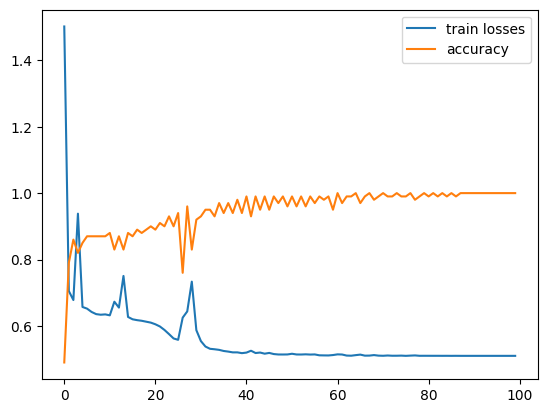

In [146]:
plt.plot(train_losses, label='train losses')
plt.plot(accuracys, label='accuracy')
plt.legend()

(-1.5852036713415494, 1.9147963286584506)

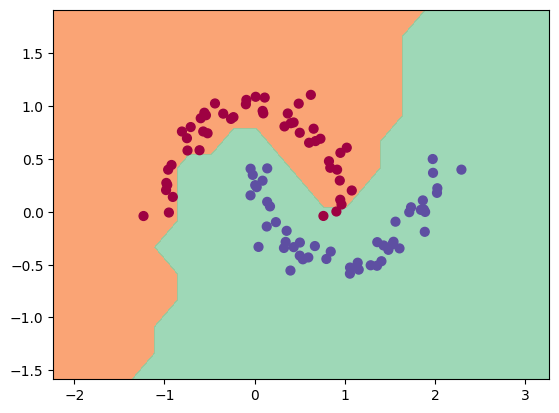

In [147]:
h = 0.25
x_min, x_max = data_X[:, 0].min() - 1, data_X[:, 0].max() + 1
y_min, y_max = data_X[:, 1].min() - 1, data_X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [168]:
1 + -Value(3)*3

Value(data=-8.0 grad_fn=<function Value.__add__.<locals>._grad_fn at 0x7d20ee261300> grad=0.0)